# Activity: Hypothesis testing with Python
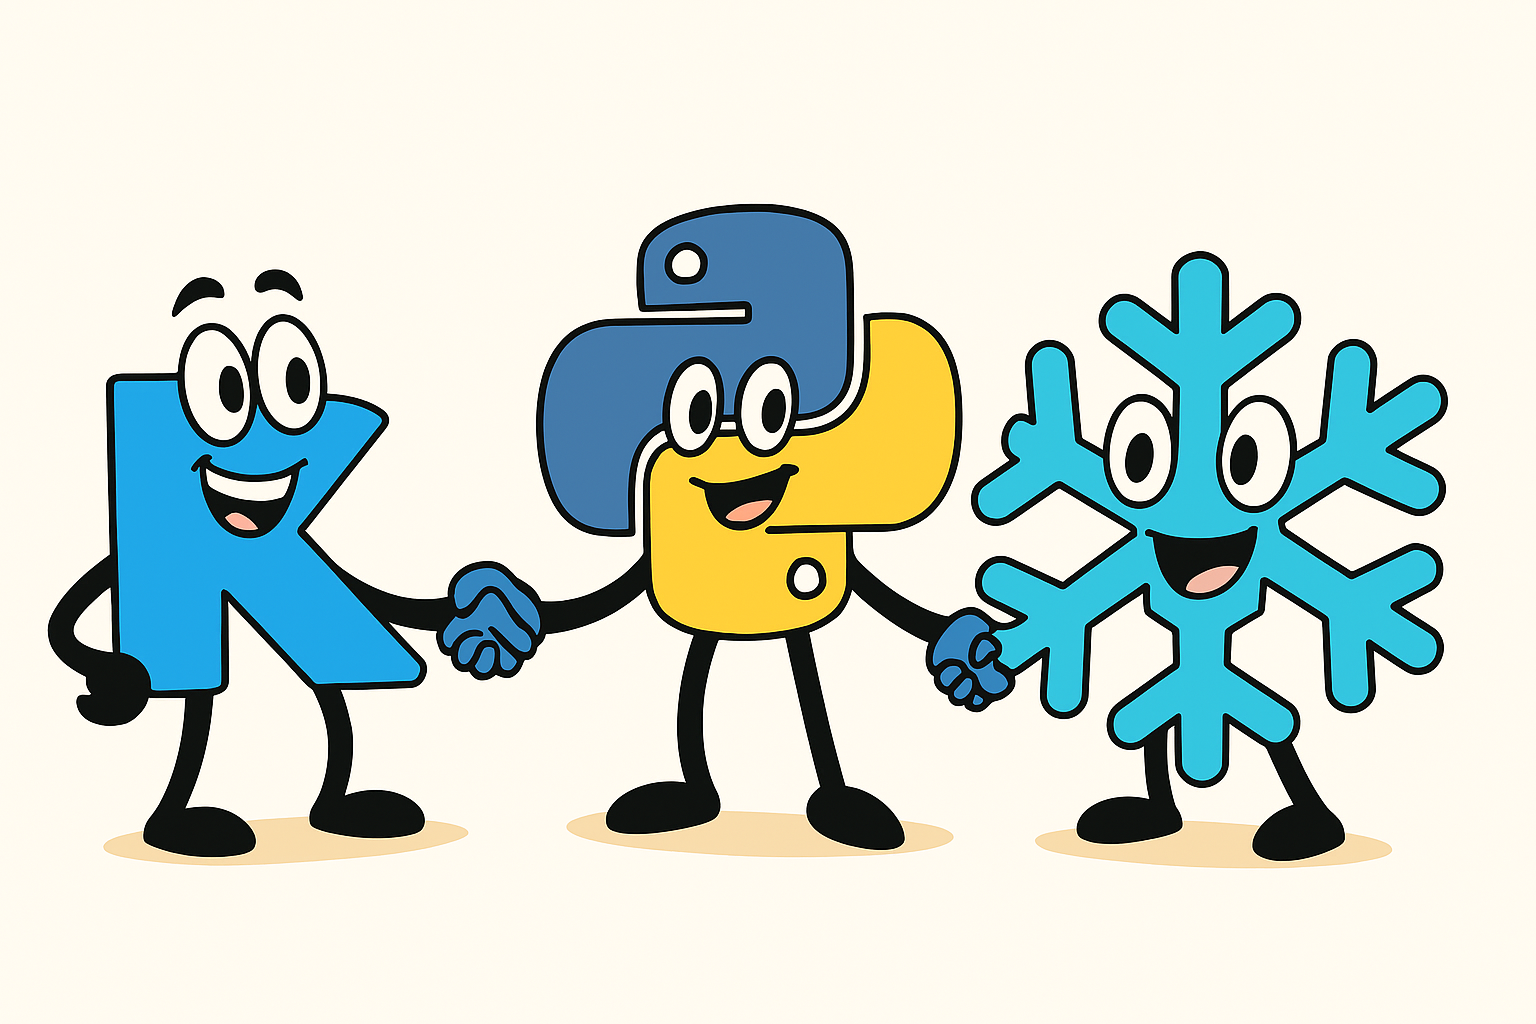

## **Introduction**


As you've been learning, analysis of variance (commonly called ANOVA) is a group of statistical techniques that test the difference of means among three or more groups. It's a powerful tool for determining whether population means are different across groups and for answering a wide range of business questions.

In this activity, you are a data professional working with historical marketing promotion data. You will use the data to run a one-way ANOVA and a post hoc ANOVA test. Then, you will communicate your results to stakeholders. These experiences will help you make more confident recommendations in a professional setting. 

In your dataset, each row corresponds to an independent marketing promotion, where your business uses TV, social media, radio, and influencer promotions to increase sales. You have previously provided insights about how different promotion types affect sales; now stakeholders want to know if sales are significantly different among various TV and influencer promotion types.

To address this request, a one-way ANOVA test will enable you to determine if there is a statistically significant difference in sales among groups. This includes:
* Using plots and descriptive statistics to select a categorical independent variable
* Creating and fitting a linear regression model with the selected categorical independent variable
* Checking model assumptions
* Performing and interpreting a one-way ANOVA test
* Comparing pairs of groups using an ANOVA post hoc test
* Interpreting model outputs and communicating the results to nontechnical stakeholders

## **Step 1: Imports** 


Import pandas, pyplot from matplotlib, seaborn, api from statsmodels, ols from statsmodels.formula.api, and pairwise_tukeyhsd from statsmodels.stats.multicomp.

In [2]:
# Import libraries and packages.

### YOUR CODE HERE ### 
import snowflake.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


`Pandas` was used to load the dataset `marketing_sales_data.csv` as `data`, now display the first five rows. The variables in the dataset have been adjusted to suit the objectives of this lab. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

In [3]:
# RUN THIS CELL TO IMPORT YOUR DATA.
import snowflake.snowpark as snowpark
from snowflake.snowpark.types import StructType, StructField, StringType, FloatType

def import_data(session: snowpark.Session):
    # Define the path to your staged CSV file 
    file_location = "@MY_CSV_STAGE/marketing_sales_data.csv" 

    # Define the schema based on your uploaded file
    schema_for_file = StructType([
        StructField("TV", StringType()),           # categorical: Low, Medium, High
        StructField("Radio", FloatType()),         # numeric values
        StructField("SocialMedia", FloatType()),   # numeric values
        StructField("Influencer", StringType()),   # categorical: Micro, Macro, Mega, Nano
        StructField("Sales", FloatType())          # numeric values
    ])

    # Read the CSV file into a Snowpark DataFrame 
    data = session.read.schema(schema_for_file).option("HEADER", "TRUE").csv(file_location)

    # Return the DataFrame
    return data

# Create a Snowpark session
from snowflake.snowpark import Session

connection_parameters = {
    "account": "******",
    "user": "******",
    "password": "******",
    "role": "******",
    "warehouse": "******",
    "database": "******",
    "schema": "PUBLIC"   # <-- use PUBLIC instead of INFORMATION_SCHEMA
}

session = Session.builder.configs(connection_parameters).create()

# Call the function and assign the result to a variable
data = import_data(session)
data.show(5)

# Convert to pandas DataFrame
data = data.to_pandas()
data.head(5)


,TV,Radio,Social Media,Influencer,Sales
0,Low,1.218354,1.270444,Micro,90.054222
1,Medium,14.949791,0.274451,Macro,222.741668
2,Low,10.377258,0.061984,Mega,102.774790
3,High,26.469274,7.070945,Micro,328.239378
4,High,36.876302,7.618605,Mega,351.807328


The features in the data are:
* TV promotion budget (in Low, Medium, and High categories)
* Social media promotion budget (in millions of dollars)
* Radio promotion budget (in millions of dollars)
* Sales (in millions of dollars)
* Influencer size (in Mega, Macro, Nano, and Micro categories)

**Question:** Why is it useful to perform exploratory data analysis before constructing a linear regression model?

* To understand which variables are present in the data
* To consider the distribution of features, such as minimum, mean, and maximum values
* To plot the relationship between the independent and dependent variables and visualize which features have a linear relationship
* To identify issues with the data, such as incorrect or missing values.

## **Step 2: Data exploration** 


First, use a boxplot to determine how `Sales` vary based on the `TV` promotion budget category.

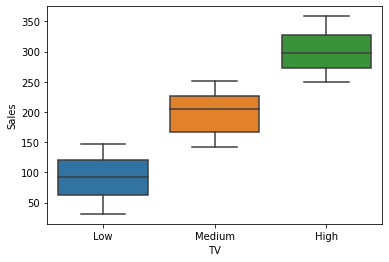

In [4]:
# Create a boxplot with TV and Sales.

### YOUR CODE HERE ### 
sns.boxplot(x= "TV", y = "SALES", data = data);

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

There is a function in the `seaborn` library that creates a boxplot showing the distribution of a variable across multiple groups.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the `boxplot()` function from `seaborn`.

</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use `TV` as the `x` argument, `Sales` as the `y` argument, and `data` as the `data` argument.

</details>

**Question:** Is there variation in `Sales` based off the `TV` promotion budget?

There is considerable variation in `Sales` across the `TV` groups. The significance of these differences can be tested with a one-way ANOVA.

Now, use a boxplot to determine how `Sales` vary based on the `Influencer` size category.

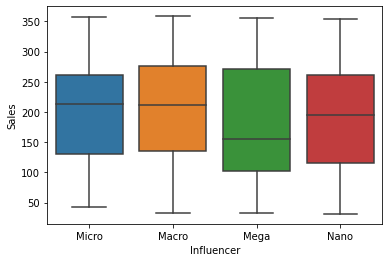

In [6]:
# Create a boxplot with Influencer and Sales.

### YOUR CODE HERE ### 
sns.boxplot(x= "INFLUENCER", y = "SALES", data = data);


**Question:** Is there variation in `Sales` based off the `Influencer` size?

There is some variation in `Sales` across the `Influencer` groups, but it may not be significant.

### Remove missing data

You may recall from prior labs that this dataset contains rows with missing values. To correct this, drop these rows. Then, confirm the data contains no missing values.

In [7]:
# Drop rows that contain missing data and update the DataFrame.

### YOUR CODE HERE ### 

data = data.dropna(axis=0)


# Confirm the data contains no missing values.

### YOUR CODE HERE ### 

data.isnull().sum(axis=0)

TV              0
Radio           0
Social Media    0
Influencer      0
Sales           0
dtype: int64

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

There is a `pandas` function that removes missing values.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

The `dropna()` function removes missing values from an object (e.g., DataFrame).

</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Verify the data is updated properly after the rows containing missing data are dropped.

</details>

## **Step 3: Model building** 


Fit a linear regression model that predicts `Sales` using one of the independent categorical variables in `data`. Refer to your previous code for defining and fitting a linear regression model.

In [9]:
# Define the OLS formula.

### YOUR CODE HERE ### 

ols_formula = 'SALES ~ C(TV)'


# Create an OLS model.

### YOUR CODE HERE ### 

OLS =ols(formula = ols_formula, data = data)

# Fit the model.

### YOUR CODE HERE ### 

model = OLS.fit()

# Save the results summary.

### YOUR CODE HERE ### 

model_results = model.summary()

# Display the model results.

### YOUR CODE HERE ### 

model_results


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1971.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          8.81e-256
Time:                        03:51:34   Log-Likelihood:                -2778.9
No. Observations:                 569   AIC:                             5564.
Df Residuals:                     566   BIC:                             5577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         300.5296      2.417    124.360      0.000     295.783     305.276
C(TV)[T.Low]     -208.8133      3.329    -62.720      0.000    -215.353    -202.274
C(TV)[T.Medium]  -101.5061      3.325    -30.526      0.000    -108.038     -94.975
==============================================================================
Omnibus:                      450.714   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.763
Skew:                          -0.044   Prob(JB):                     1.71e-08
Kurtosis:                       1.775   Cond. No.                         3.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Refer to code you've written to fit linear regression models.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the `ols()` function from `statsmodels.formula.api`, which creates a model from a formula and DataFrame, to create an OLS model.

</details>


<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use `C()` around the variable name in the ols formula to indicate a variable is categorical.
    
Be sure the variable string names exactly match the column names in `data`.

</details>

**Question:** Which categorical variable did you choose for the model? Why?

* `TV` was selected as the preceding analysis showed a strong relationship between the `TV` promotion budget and the average `Sales`.
* `Influencer` was not selected because it did not show a strong relationship to `Sales` in the analysis.

### Check model assumptions

Now, check the four linear regression assumptions are upheld for your model.

**Question:** Is the linearity assumption met?

The model does not have any continuous independent variables, the linearity assumption is not required

The independent observation assumption states that each observation in the dataset is independent. As each marketing promotion (row) is independent from one another, the independence assumption is not violated.

Next, verify that the normality assumption is upheld for the model.

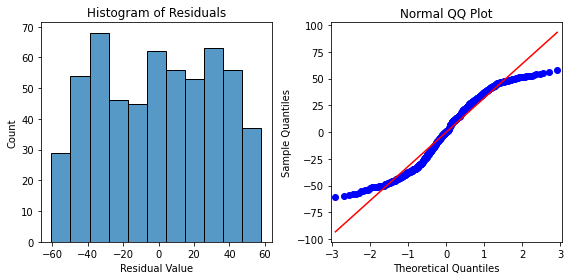

In [10]:
# Calculate the residuals.

### YOUR CODE HERE ### 

residuals = model.resid

# Create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))

# Create a histogram with the residuals. 

### YOUR CODE HERE ### 

sns.histplot(residuals, ax=axes[0])

# Set the x label of the residual plot.
axes[0].set_xlabel("Residual Value")

# Set the title of the residual plot.
axes[0].set_title("Histogram of Residuals")

# Create a QQ plot of the residuals.

### YOUR CODE HERE ### 

sm.qqplot(residuals, line='s', ax = axes[1])

# Set the title of the QQ plot.
axes[1].set_title("Normal QQ Plot")

# Use matplotlib's tight_layout() function to add space between plots for a cleaner appearance
plt.tight_layout()

# Show the plot
plt.show()


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Access the residuals from the fit model object.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use `model.resid` to get the residuals from a fit model called `model`.

</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

For the histogram, pass the residuals as the first argument in the `seaborn` `histplot()` function.
    
For the QQ-plot, pass the residuals as the first argument in the `statsmodels` `qqplot()` function.

</details>

**Question:** Is the normality assumption met?

There is reasonable concern that the normality assumption is not met when `TV` is used as the independent variable predicting `Sales`. The normal q-q forms an 'S' that deviates off the red diagonal line, which is not desired behavior. 

However, for the purpose of the lab, continue assuming the normality assumption is met.

Now, verify the constant variance (homoscedasticity) assumption is met for this model.

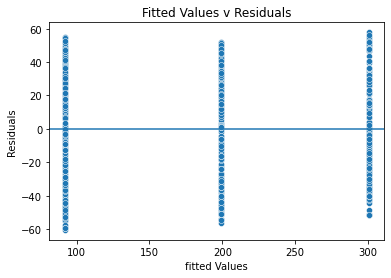

In [11]:
# Create a scatter plot with the fitted values from the model and the residuals.

### YOUR CODE HERE ### 

fig = sns.scatterplot(x = model.fittedvalues, y = model.resid)

# Set the x axis label
fig.set_xlabel("fitted Values")

# Set the y axis label
fig.set_ylabel("Residuals")

# Set the title
fig.set_title("Fitted Values v Residuals")

# Add a line at y = 0 to visualize the variance of residuals above and below 0.

### YOUR CODE HERE ### 
fig.axhline(0)

# Show the plot
plt.show()

<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Access the fitted values from the model object fit earlier.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use `model.fittedvalues` to get the fitted values from the fit model called `model`.

</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>


Call the `scatterplot()` function from the `seaborn` library and pass in the fitted values and residuals.
    
Add a line to a figure using the `axline()` function.

</details>

**Question:** Is the constant variance (homoscedasticity) assumption met?

The variance where there are fitted values is similarly distributed, validating that the constant variance assumption is met.

## **Step 4: Results and evaluation** 

First, display the OLS regression results.

In [12]:
# Display the model results summary.

### YOUR CODE HERE ### 

model_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     1971.
Date:                Fri, 14 Nov 2025   Prob (F-statistic):          8.81e-256
Time:                        03:51:34   Log-Likelihood:                -2778.9
No. Observations:                 569   AIC:                             5564.
Df Residuals:                     566   BIC:                             5577.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         300.5296      2.417    124.360      0.000     295.783     305.276
C(TV)[T.Low]     -208.8133      3.329    -62.720      0.000    -215.353    -202.274
C(TV)[T.Medium]  -101.5061      3.325    -30.526      0.000    -108.038     -94.975
==============================================================================
Omnibus:                      450.714   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.763
Skew:                          -0.044   Prob(JB):                     1.71e-08
Kurtosis:                       1.775   Cond. No.                         3.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question:** What is your interpretation of the model's R-squared?

Using `TV` as the independent variable results in a linear regression model with $R^{2} = 0.874$. In other words, the model explains $87.4\%$ of the variation in `Sales`. This makes the model an effective predictor of `Sales`. 

**Question:** What is your intepretation of the coefficient estimates? Are the coefficients statistically significant?

The default `TV` category for the model is `High`, because there are coefficients for the other two `TV` categories, `Medium` and `Low`. According to the model, `Sales` with a `Medium` or `Low` `TV` category are lower on average than `Sales` with a `High` `TV` category. For example, the model predicts that a `Low` `TV` promotion would be 208.813 (in millions of dollars) lower in `Sales` on average than a `High` `TV` promotion.

The p-value for all coefficients is $0.000$, meaning all coefficients are statistically significant at $p=0.05$. The 95% confidence intervals for each coefficient should be reported when presenting results to stakeholders. For instance, there is a $95\%$ chance the interval $[-215.353,-202.274]$ contains the true parameter of the slope of $\beta_{TVLow}$, which is the estimated difference in promotion sales when a `Low` `TV` promotion is chosen instead of a `High` `TV` promotion.

**Question:** Do you think your model could be improved? Why or why not? How?

Given how accurate `TV` was as a predictor, the model could be improved with a more granular view of the `TV` promotions, such as additional categories or the actual `TV` promotion budgets. Further, additional variables, such as the location of the marketing campaign or the time of year, may increase model accuracy. 

### Perform a one-way ANOVA test

With the model fit, run a one-way ANOVA test to determine whether there is a statistically significant difference in `Sales` among groups. 

In [13]:
# Create an one-way ANOVA table for the fit model.

### YOUR CODE HERE ### 

sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(TV),4.052692e+06,2.0,1971.455737,8.805550e-256
Residual,5.817589e+05,566.0,NaN,NaN


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Review what you've learned about how to perform a one-way ANOVA test.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

There is a function in `statsmodels.api` (i.e. `sm`) that peforms an ANOVA test for a fit linear model.

</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

Use the `anova_lm()` function from `sm.stats`. Specify the type of ANOVA test (for example, one-way or two-way), using the `typ` parameter.
   

</details>

**Question:** What are the null and alternative hypotheses for the ANOVA test?

The null hypothesis is that there is no difference in `Sales` based on the `TV` promotion budget.

The alternative hypothesis is that there is a difference in `Sales` based on the `TV` promotion budget.

**Question:** What is your conclusion from the one-way ANOVA test?

The F-test statistic is 1971.46 and the p-value is $8.81 * 10^{-256}$ (i.e., very small). Because the p-value is less than 0.05, you would reject the null hypothesis that there is no difference in `Sales` based on the `TV` promotion budget.

**Question:** What did the ANOVA test tell you?

The results of the one-way ANOVA test indicate that you can reject the null hypothesis in favor of the alternative hypothesis. There is a statistically significant difference in `Sales` among `TV` groups.

### Perform an ANOVA post hoc test

If you have significant results from the one-way ANOVA test, you can apply ANOVA post hoc tests such as the Tukey’s HSD post hoc test. 

Run the Tukey’s HSD post hoc test to compare if there is a significant difference between each pair of categories for TV.

In [14]:
# Perform the Tukey's HSD post hoc test.

### YOUR CODE HERE ### 

tukey_oneway = pairwise_tukeyhsd(endog = data["SALES"], groups = data["TV"])

# Display the results
print(tukey_oneway.summary())

group1,group2,meandiff,p-adj,lower,upper,reject
High,Low,-208.8133,0.001,-216.637,-200.9896,True
High,Medium,-101.5061,0.001,-109.3204,-93.6918,True
Low,Medium,107.3072,0.001,99.7063,114.908,True


<details>
<summary><h4><strong>Hint 1</strong></h4></summary>

Review what you've learned about how to perform a Tukey's HSD post hoc test.

</details>

<details>
<summary><h4><strong>Hint 2</strong></h4></summary>

Use the `pairwise_tukeyhsd()` function from `statsmodels.stats.multicomp`.

</details>

<details>
<summary><h4><strong>Hint 3</strong></h4></summary>

The `endog` argument in `pairwise_tukeyhsd` indicates which variable is being compared across groups (i.e., `Sales`). The `groups` argument in `pairwise_tukeyhsd` tells the function which variable holds the group you’re interested in reviewing.

</details>

**Question:** What is your interpretation of the Tukey HSD test?

The first row, which compares the `High` and `Low` `TV` groups, indicates that you can reject the null hypothesis that there is no significant difference between the `Sales` of these two groups.

You can also reject the null hypotheses for the two other pairwise comparisons that compare `High` to `Medium` and `Low` to `Medium`.

**Question:** What did the post hoc tell you?**

A post hoc test was conducted to determine which `TV` groups are different and how many are different from each other. This provides more detail than the one-way ANOVA results, which can at most determine that at least one group is different. Further, using the Tukey HSD controls for the increasing probability of incorrectly rejecting a null hypothesis from peforming multiple tests. 

The results were that `Sales` is not the same between any pair of `TV` groups. 

## **Considerations**

**What are some key takeaways that you learned during this lab?**

* Box-plots are a helpful tool for visualizing the distribution of a variable across groups.
* One-way ANOVA can be used to determine if there are significant differences among the means of three or more groups.
* ANOVA post hoc tests provide a more detailed view of the pairwise differences between groups.


**What summary would you provide to stakeholders? Consider the statistical significance of key relationships and differences in distribution.**

Specifically, following are estimates for the difference between the mean sales resulting from different pairs of TV promotions, as determined by the Tukey's HSD test:

* Estimated difference between the mean sales resulting from High and Low TV promotions: \\$208.81 million (with 95% confidence that the exact value for this difference is between 200.99 and 216.64 million dollars). 
* Estimated difference between the mean sales resulting from High and Medium TV promotions: \\$101.51 million (with 95% confidence that the exact value for this difference is between 93.69 and 109.32 million dollars).
* difference between the mean sales resulting from Medium and Low TV promotions: \\$107.31 million (with 95\% confidence that the exact value for this difference is between 99.71 and 114.91 million dollars).

The linear regression model estimating `Sales` from `TV` had an R-squared of $0.871, making it a fairly accurate estimator. The model showed a statistically significant relationship between the `TV` promotion budget and `Sales`. 

The results of the one-way ANOVA test indicate that the null hypothesis that there is no difference in Sales based on the TV promotion budget can be rejected. Through the ANOVA post hoc test, a significant difference between all pairs of TV promotions was found.

The difference in the distribution of sales across TV promotions was determined significant by both a one-way ANOVA test and a Tukey’s HSD test. 


#### **Reference**
[Saragih, H.S. *Dummy Marketing and Sales Data*](https://www.kaggle.com/datasets/harrimansaragih/dummy-advertising-and-sales-data)

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.